In [4]:
### import libraries

import wradlib as wrl
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import datetime as dt
# from osgeo import osr
import logging
import sys
import requests
import os

In [2]:
# Code inspired from https://developer.dataplatform.knmi.nl/open-data-api

def rain_gauge(date):
    
    # Set the API key. See https://developer.dataplatform.knmi.nl/get-started#obtain-an-api-key for more information
    api_key = "eyJvcmciOiI1ZTU1NGUxOTI3NGE5NjAwMDEyYTNlYjEiLCJpZCI6ImE1OGI5NGZmMDY5NDRhZDNhZjFkMDBmNDBmNTQyNjBkIiwiaCI6Im11cm11cjEyOCJ9"  # Public API key



    logging.basicConfig()
    logger = logging.getLogger(__name__)
    logger.setLevel("INFO")

    api_url = "https://api.dataplatform.knmi.nl/open-data"
    api_version = "v1"


    def main():
        # Parameters
        max_keys = "1"
        global filename
        #radar parameters
        dataset_name = "rain_gauge"
        filename = f"RAD_NL25_RAC_24H_{date}0800.h5"
        dataset_version = "1.0"


        # Use list files request to request file of the day.
        get_file_response  = requests.get(
            f"https://api.dataplatform.knmi.nl/open-data/v1/datasets/radar_corr_accum_24h/versions/1.0/files/{filename}/url",
            headers={"Authorization": api_key},
        )

        if get_file_response.status_code != 200:
            logger.error("Unable to retrieve download url for file")
            logger.error(get_file_response.text)
            sys.exit(1)

        logger.info(f"Successfully retrieved temporary download URL for dataset file {filename}")

        download_url = get_file_response.json().get("temporaryDownloadUrl")
        # Check logging for deprecation
        if "X-KNMI-Deprecation" in get_file_response.headers:
            deprecation_message = get_file_response.headers.get("X-KNMI-Deprecation")
            logger.warning(f"Deprecation message: {deprecation_message}")

        download_file_from_temporary_download_url(download_url, filename)


    def download_file_from_temporary_download_url(download_url, filename):
        try:
            with requests.get(download_url, stream=True) as r:
                r.raise_for_status()
                with open(filename, "wb") as f:
                    for chunk in r.iter_content(chunk_size=8192):
                        f.write(chunk)
        except Exception:
            logger.exception("Unable to download file using download URL")
            sys.exit(1)

        logger.info(f"Successfully downloaded dataset file to {filename}")


    if __name__ == "__main__":
        main()
    return



INFO:__main__:Successfully retrieved temporary download URL for dataset file RAD_NL25_RAC_24H_201801010800.h5
INFO:__main__:Successfully downloaded dataset file to RAD_NL25_RAC_24H_201801010800.h5
INFO:__main__:Successfully retrieved temporary download URL for dataset file RAD_NL25_RAC_24H_201801020800.h5
INFO:__main__:Successfully downloaded dataset file to RAD_NL25_RAC_24H_201801020800.h5
INFO:__main__:Successfully retrieved temporary download URL for dataset file RAD_NL25_RAC_24H_201801030800.h5
INFO:__main__:Successfully downloaded dataset file to RAD_NL25_RAC_24H_201801030800.h5
INFO:__main__:Successfully retrieved temporary download URL for dataset file RAD_NL25_RAC_24H_201801040800.h5
INFO:__main__:Successfully downloaded dataset file to RAD_NL25_RAC_24H_201801040800.h5
INFO:__main__:Successfully retrieved temporary download URL for dataset file RAD_NL25_RAC_24H_201801050800.h5
INFO:__main__:Successfully downloaded dataset file to RAD_NL25_RAC_24H_201801050800.h5
INFO:__main__:S

(array([288.,  33.,  24.,   5.,   2.,   6.,   2.,   0.,   1.,   1.]),
 array([   0. ,  200.2,  400.4,  600.6,  800.8, 1001. , 1201.2, 1401.4,
        1601.6, 1801.8, 2002. ]),
 <BarContainer object of 10 artists>)

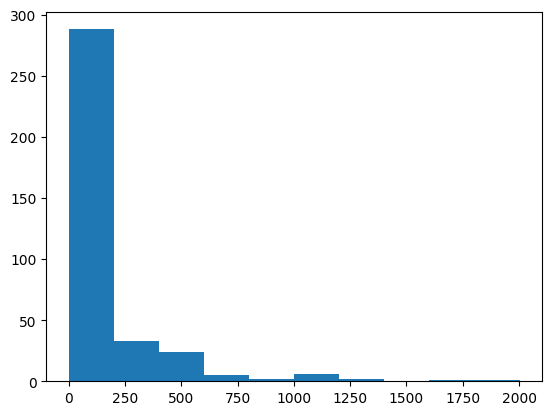

In [3]:
rain_gauge_ = []    # list of daily rain gauge values
year = "2018"
date = "20180101"   # start date
for i in range(365):    # 365 days
    
    # convert date to datetime object
    dateObject = dt.datetime.strptime(date, '%Y%m%d')
    
    try:
        # download rain gauge data
        rain_gauge(date)
        
        # read rain gauge data and remove nan values
        rain = wrl.io.read_opera_hdf5(filename)
        img2 = rain["image1/image_data"].astype(np.float32)
        img2[img2 == 65535] = float("nan")

        # calculate daily rain gauge median value (to get the most contant values)
        rain_gauge_.append(np.nanmedian(img2))
        
        # go the the next date
        date = dateObject + dt.timedelta(days=1)
        date = date.strftime('%Y%m%d')
        
        os.remove(filename)    # remove downloaded file
 
    except:
        
        # if there is no rain gauge data for a day, append nan value
        rain_gauge_.append(np.array(float("NaN")))
        
        # go the the next date
        date = dateObject + dt.timedelta(days=1)
        date = date.strftime('%Y%m%d')
    
    
plt.hist(rain_gauge_)
np.save(f"rain_gauge_{year}.npy",rain_gauge_)

In [6]:
# year = "2022"

# rain_gauge_ = np.load(f"rain_gauge_{year}.npy")

# remove nan values
rain_gauge_ = np.nan_to_num(rain_gauge_,nan=0)

# calculate 90% quantile
quant_95 = np.quantile(rain_gauge_,0.94)

# find days with rain gauge values higher than 90% quantile
days = np.argwhere(rain_gauge_ > quant_95)

quant_95_days = []

for day in days:

    # converting the day number
    day_num = str(day[0]+1)

    # converting the day number to date
    res = datetime.strptime(year + "-" + day_num, "%Y-%j").strftime('%Y%m%d')

    quant_95_days.append(res)
    
print(quant_95_days)

with open(f"rain_gauge.txt","a") as f:
    f.write(f"\n\n95% quantile for {year}:\n\n")
    for line in quant_95_days:
        f.write(f"{line}, ")

['20220109', '20220206', '20220207', '20220216', '20220220', '20220221', '20220407', '20220520', '20220521', '20220524', '20220606', '20220609', '20220701', '20220927', '20220928', '20221001', '20221104', '20221107', '20221116', '20221117', '20221128', '20221224']
